In [39]:
import keras.models as models
from skimage.transform import resize
from skimage.io import imsave

import tensorflow as tf
from keras import backend as K

from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, AveragePooling3D, ZeroPadding3D
from keras.initializers import RandomNormal
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import concatenate
from keras.models import Model

from keras.optimizers import Adam
from keras.regularizers import l2
from keras.utils import plot_model


import tensorflow_addons as tfa
from keras.callbacks import ModelCheckpoint, CSVLogger

import numpy as np
import os
from tqdm import tqdm
import nibabel as nib
import random
import matplotlib.pyplot as plt
%matplotlib notebook

In [40]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    print(e)

print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

1 Physical GPUs, 1 Logical GPUs
GPU is available


In [41]:
IMG_ROWS = 256
IMG_COLS = 256
IMG_DEPTH = 192

BASE_DIR = '/kaggle'
TRAIN_DATA_PATH = os.path.join(BASE_DIR, 'input', 'mri-brain-dataset', 'NFBS_MRI_SKULL') #Biias Corrected
TEST_DATA_PATH = os.path.join(BASE_DIR, 'input', 'mri-brain-dataset', 'NFBS_MRI_SKULL') #Bias Corrected

if not os.path.exists('/kaggle/working/Models'):
    os.mkdir('/kaggle/working/Models')



In [42]:
#Normalize images
def normalize(image):
    image = image.astype('float32')
    range = image.max() - image.min()
    image_min = image.min()
    return (image - image_min)*255/range

#Read an image from disk. Images are stored in nii.gz format
def read_image(img_path):
    image = nib.load(img_path).get_data()
    #image = normalize(image)
    return image

# Load data from disk
def load_data_from_disk(v):
    images_mask = None
    if v == 'Training':
        images, images_mask = read_images()
    else:
        images = read_test_images()
    return images, images_mask

#Sample n images 
def read_n_images(n=10, stripped=False):
    list_dirs = os.listdir(TRAIN_DATA_PATH)
    N = len(list_dirs)
    random.shuffle(list_dirs)
    images = np.zeros((n,IMG_ROWS, IMG_COLS, IMG_DEPTH), dtype=np.float32)
    image_masks = np.zeros((n,IMG_ROWS, IMG_COLS, IMG_DEPTH), dtype=np.float32)
    stripped_images = np.zeros((n,IMG_ROWS, IMG_COLS, IMG_DEPTH), dtype=np.float32)
    

    for i in tqdm(range(n)):
        dir = list_dirs[i]
        d_path = os.path.join(TRAIN_DATA_PATH, dir)
        if not os.path.isdir(d_path):
            continue

        files = os.listdir(d_path)
        for file in files:
            file_path = os.path.join(d_path, file)
            if file.find('brain') == -1:
                image = read_image(file_path)
                image = normalize(image)
            elif file.find('brainmask') != -1:
                image_mask = read_image(file_path)
            else:
                if stripped == True:
                    stripped_image = read_image(file_path)
        
        images[i] = image
        image_masks[i] = image_mask
        stripped_images[i] = stripped_image
    
    if stripped == True:
        return images, image_masks, stripped_images
    else:
        return images, image_masks
        

#Load MRI data from disk. Images are stored in nii.gz format
def read_images():
    list_dirs = os.listdir(TRAIN_DATA_PATH)
    N = len(list_dirs)
    images = np.zeros((N,IMG_ROWS, IMG_COLS, IMG_DEPTH), dtype=np.float32)
    image_masks = np.zeros((N,IMG_ROWS, IMG_COLS, IMG_DEPTH), dtype=np.float32)
    i = 0

    for dir in tqdm(list_dirs):
        d_path = os.path.join(TRAIN_DATA_PATH, dir)
        if not os.path.isdir(d_path):
            continue

        files = os.listdir(d_path)
        for file in files:
            file_path = os.path.join(d_path, file)
            if file.find('brain') == -1:
                image = read_image(file_path)
                image = normalize(image)
            elif file.find('brainmask') != -1:
                image_mask = read_image(file_path)
            else:
                pass
        images[i] = image
        image_masks[i] = image_mask
        i += 1

    return images, image_masks

#Load Test MRI data from disk. Images are stored in nii.gz format
def read_test_images():
    list_dirs = os.listdir(TEST_DATA_PATH)
    N = len(list_dirs)
    images = np.zeros((N,IMG_ROWS, IMG_COLS, IMG_DEPTH), dtype=np.float32)
    i = 0

    for dir in tqdm(list_dirs):
        d_path = os.path.join(TEST_DATA_PATH, dir)
        if not os.path.isdir(d_path):
            continue

        files = os.listdir(d_path)
        for file in files:
            file_path = os.path.join(d_path, file)
            if file.find('brain') == -1:
                image = read_image(file_path)
                image = normalize(image)

        images[i] = image
        i += 1

    return images


  0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  # Remove the CWD from sys.path while we load stuff.
100%|██████████| 3/3 [00:04<00:00,  1.47s/it]


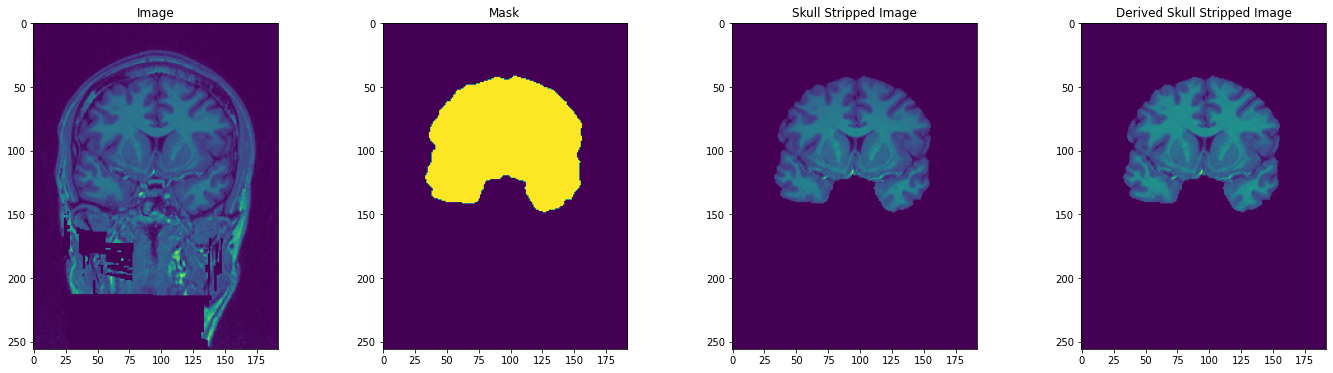

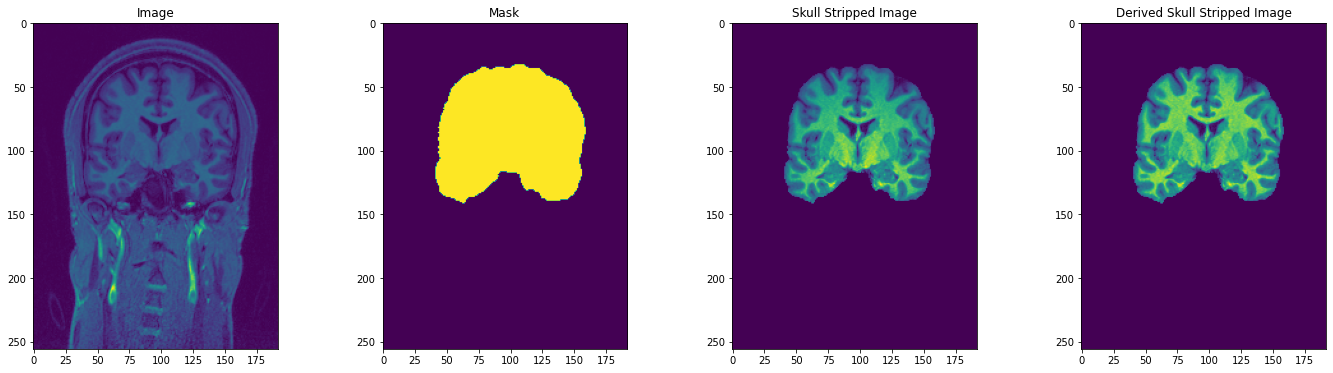

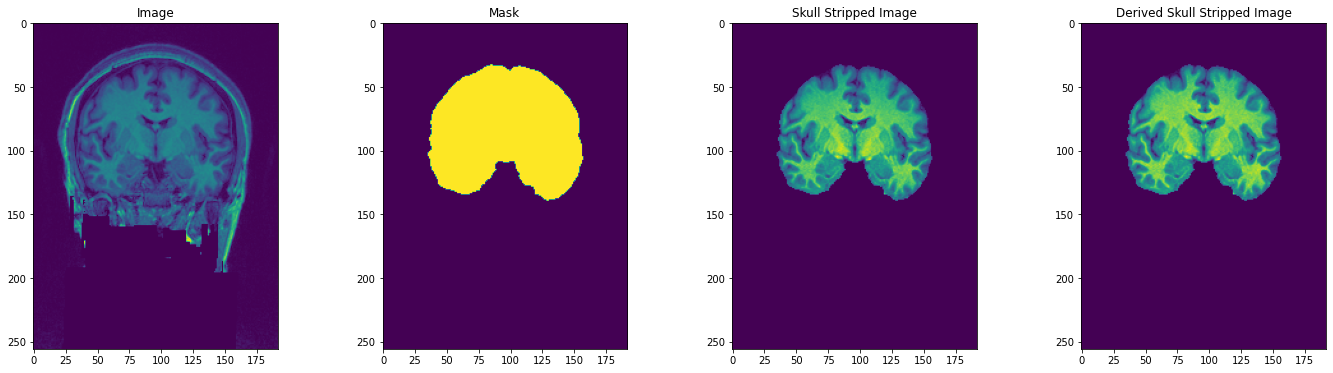

In [43]:
%matplotlib inline
def display_images(image, image_mask, stripped_image):
    derived_image = image * image_mask
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize = (24, 6))
    ax1.imshow(image[image.shape[0]//2])
    ax1.set_title('Image')
    ax2.imshow(image_mask[image_mask.shape[0]//2])
    ax2.set_title('Mask')
    ax3.imshow(stripped_image[stripped_image.shape[0]//2])
    ax3.set_title('Skull Stripped Image')
    ax4.imshow(derived_image[derived_image.shape[0]//2])
    ax4.set_title('Derived Skull Stripped Image')
    plt.show()


n = 3
images, image_masks, stripped_images = read_n_images(n, stripped=True)

for i in range(n):
    display_images(images[i], image_masks[i], stripped_images[i])
    
    

In [44]:
#Metric for Segmentation Similarity
def dice_coefficient(y_true, y_pred):
    SMOOTH = 1.0
    y_true_flat = K.flatten(y_true)
    y_pred_flat = K.flatten(y_pred)
    intersection = K.sum(y_true_flat * y_pred_flat)
    return (2. * intersection + SMOOTH) / (K.sum(y_true_flat) + K.sum(y_pred_flat) + SMOOTH)


In [45]:
#Create Training and Validation Generator
def get_generators(ratio=0.2, batch_size=8):
    list_dirs = os.listdir(TRAIN_DATA_PATH)
    N = len(list_dirs)
    random.shuffle(list_dirs)
    n_validation = (int)(N*0.2)
    n_train = N - n_validation

    train_generator = data_generator(list_dirs[0:n_train], batch_size,shuffle_data=True)
    validation_generator = data_generator(list_dirs[n_train:N], batch_size,shuffle_data=True)

    train_steps_epoch = n_train//batch_size
    if n_train%batch_size != 0:
        train_steps_epoch += 1

    validation_steps_epoch = n_validation//batch_size
    if n_validation%batch_size != 0:
        validation_steps_epoch += 1

    return train_generator, train_steps_epoch, validation_generator, validation_steps_epoch

#Create Generator
def data_generator(list_dirs, batch_size=8,shuffle_data=True):
    N = len(list_dirs)
    step_epoch = N//batch_size
    if N%batch_size != 0:
        step_epoch += 1

    while True:
        i = 0
        m = 0
        random.shuffle(list_dirs)

        while i < step_epoch:
            n = N - m
            if n >= batch_size:
                images = np.zeros((batch_size,IMG_ROWS, IMG_COLS, IMG_DEPTH), dtype=np.float32)
                image_masks = np.zeros((batch_size, IMG_ROWS, IMG_COLS, IMG_DEPTH), dtype=np.float32)
                delta_step = batch_size
            else:
                images = np.zeros((n, IMG_ROWS, IMG_COLS, IMG_DEPTH), dtype=np.float32)
                image_masks = np.zeros((n, IMG_ROWS, IMG_COLS, IMG_DEPTH), dtype=np.float32)
                delta_step = n

            k = 0
            while k < delta_step:
                dir = list_dirs[m]
                m += 1
                d_path = os.path.join(TRAIN_DATA_PATH, dir)
                files = os.listdir(d_path)
                for file in files:
                    file_path = os.path.join(d_path, file)
                    if file.find('brain') == -1:
                        image = read_image(file_path)
                        image = normalize(image)
                    elif file.find('brainmask') != -1:
                        image_mask = read_image(file_path)
                    else:
                        pass
                images[k] = image
                image_masks[k] = image_mask
                k += 1

            i += 1
            yield images, image_masks

            images = None
            images_mask = None

    yield np.zeros((0,0)), np.zeros((0,0))


In [46]:
#Emcoder Block
def encoder_block(input, filters, kernel_size, activation='relu', padding='same', pooling=True, batchnorm = True):
    init = RandomNormal(stddev=0.02)
    conv_1 = Conv2D(filters, (kernel_size, kernel_size), padding= padding,  kernel_initializer=init)(input)
    if batchnorm:
        g = BatchNormalization()(conv_1, training=True)

    g = LeakyReLU(alpha=0.2)(conv_1)
    concat_1 = concatenate([input, g], axis=3)
    conv_2 = Conv2D(filters, (kernel_size, kernel_size), padding= padding, kernel_initializer=init)(concat_1)

    if batchnorm:
        g = BatchNormalization()(conv_2, training=True)
   
    concat_2 = concatenate([input, g], axis=3)

    if pooling == True:
        output = MaxPooling2D(pool_size=(2, 2))(concat_2)
        g = LeakyReLU(alpha=0.2)(output)
        return  g, concat_2
    else:
        return concat_2


#Decoder Block
def decoder_block(input, encoded_block, filters, kernel_size_t, kernel_size, strides, activation='relu', padding='same', dropout = True):
    init = RandomNormal(stddev=0.02)
    conv_up_1 = Conv2DTranspose(filters, (kernel_size_t, kernel_size_t), strides=(strides, strides), padding=padding)(input)
    g = BatchNormalization()(conv_up_1)
    concat_1  = concatenate([g, encoded_block], axis=3)
    conv_1 = Conv2D(filters, (kernel_size, kernel_size), activation=activation, padding=padding, kernel_initializer=init)(concat_1)
    concat_2 = concatenate([concat_1, conv_1], axis=3)
    conv_2 = Conv2D(filters, (kernel_size, kernel_size), activation=activation, padding=padding, kernel_initializer=init)(concat_2)

    if dropout == True:
        g = Dropout(0.5)(conv_2, training=True)

    output = concatenate([concat_1, conv_2], axis=3)
    g = Activation('relu')(output)

    return g

   


In [47]:
#Create Model
def create_model(img_rows, img_cols):
    #inputs = Input((IMG_ROWS, IMG_COLS, 3))
    inputs = Input((IMG_ROWS, IMG_COLS, 192))

    encoded_block_11, encoded_block_12 = encoder_block(input=inputs, filters=32,  kernel_size=3, batchnorm=False)
    encoded_block_21, encoded_block_22 = encoder_block(input=encoded_block_11, filters=64,   kernel_size=3)
    encoded_block_31, encoded_block_32 = encoder_block(input=encoded_block_21, filters=128,  kernel_size=3)
    encoded_block_41, encoded_block_42 = encoder_block(input=encoded_block_31, filters=256,  kernel_size=3)
    encoded_block_51, encoded_block_52 = encoder_block(input=encoded_block_41, filters=512,  kernel_size=3)
    encoded_block_61, encoded_block_62 = encoder_block(input=encoded_block_51, filters=512,  kernel_size=3)
    encoded_block = encoder_block(input= encoded_block_61, filters=1024, kernel_size=3, pooling=False)

    encoded_block = Activation('relu')(encoded_block)

    decoded_block_6 = decoder_block(input=encoded_block,   encoded_block=encoded_block_62,filters=512, kernel_size_t=2, kernel_size=3, strides=2)
    decoded_block_5 = decoder_block(input=decoded_block_6, encoded_block=encoded_block_52,filters=512, kernel_size_t=2, kernel_size=3, strides=2)
    decoded_block_4 = decoder_block(input=decoded_block_5, encoded_block=encoded_block_42,filters=256, kernel_size_t=2, kernel_size=3, strides=2, dropout=False)
    decoded_block_3 = decoder_block(input=decoded_block_4, encoded_block=encoded_block_32,filters=128, kernel_size_t=2, kernel_size=3, strides=2, dropout=False)
    decoded_block_2 = decoder_block(input=decoded_block_3, encoded_block=encoded_block_22,filters=64,  kernel_size_t=2, kernel_size=3, strides=2, dropout=False)
    decoded_block   = decoder_block(input=decoded_block_2, encoded_block=encoded_block_12,filters=32,  kernel_size_t=2, kernel_size=3, strides=2, dropout=False)

    #output = Conv2D(192, (1, 1), activation='sigmoid')(decoded_block)
    output = Conv2D(192, (1, 1), activation='tanh')(decoded_block)

    model = Model(inputs=[inputs], outputs=[output])

    ##model.summary()
    """
    #plot_model(model, to_file='model.png')
    learning_rate = 0.001
    weight_decay = 0.0001
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )
    """
    optimizer= Adam(lr=0.0002, beta_1=0.5) #"adam"
    #model.compile(optimizer=optimizer,loss='binary_crossentropy', metrics=['accuracy'])
    model.compile(optimizer=optimizer,loss='mae', metrics=[dice_coefficient])
    """
    model.compile(optimizer=Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.000000199),
                                                    loss='binary_crossentropy', metrics=['accuracy'])
    """
    return model


In [48]:
#Training using Data Generator
def create_model_train_with_generator():
    print('---------------------------------------------------')
    print('  Loading MRI Training Meta Data from Disk         ')
    print('---------------------------------------------------')

    train_generator, train_n_step_epoch, validation_generator, validation_n_step_epoch  = get_generators(ratio=0.2, batch_size=1)

    print('---------------------------------------------------')
    print('             Creating and Fitting Model            ')
    print('---------------------------------------------------')
    model = create_model(IMG_ROWS, IMG_COLS)
    model.summary()
    
    model_weight_path = os.path.join(BASE_DIR, 'working', 'Models', 'model_weights')
    if not os.path.exists(model_weight_path):
        os.mkdir(model_weight_path)
    model_checkpoint = ModelCheckpoint(os.path.join(model_weight_path, 'skull_stripping.h5'), monitor='val_loss', save_best_only=True)

    log_dir_path = os.path.join(BASE_DIR, 'working', 'Models','logs')
    if not os.path.exists(log_dir_path):
        os.mkdir(log_dir_path)

    logger = CSVLogger(os.path.join(log_dir_path,'skull_stripping.csv'), separator=',', append=True)
    print("Logging is created at %s" %(log_dir_path))
    model.fit_generator(train_generator, steps_per_epoch = train_n_step_epoch,
                            validation_data = validation_generator,
                            validation_steps = validation_n_step_epoch,epochs=100, verbose=1, shuffle=True,
                            callbacks=[model_checkpoint, logger])
    return model

In [49]:
#Load Model from Disk
def load_model_from_disk():
    model = create_model(IMG_ROWS, IMG_COLS)
    model_weight_path = os.path.join(BASE_DIR, 'working', 'Models', 'model_weights', 'skull_stripping.h5')
    assert(os.path.exists(model_weight_path) == True), "Model path doesn't exist!"
    model.load_weights(model_weight_path)

    return model

#Display Predicted MRI Images
%matplotlib inline
from scipy.special import softmax
def display_predicted_images(image, true_stripped_image, predicted_image_mask):
    predicted_image_mask = softmax(predicted_image_mask) * predicted_image_mask#((predicted_image_mask + .1)/.2
    predicted_image = (image * (predicted_image_mask) + 1.)/2.
    #predicted_image_mask = softmax(predicted_image_mask) * predicted_image_mask#((predicted_image_mask + .1)/.2
     
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize = (24, 6))
    ax1.imshow(image[image.shape[0]//2])
    ax1.set_title('Image')
    ax2.imshow(predicted_image_mask[predicted_image_mask.shape[0]//2])
    ax2.set_title('Predicted Mask')
    ax3.imshow(true_stripped_image[true_stripped_image.shape[0]//2])
    ax3.set_title('True Skull Stripped Image')
    ax4.imshow(predicted_image[predicted_image.shape[0]//2])
    ax4.set_title('Predicted Skull Stripped Image')
    plt.show()



#Test Modeel with n random image samples using Dice Coefficient
def predict_random(n=25):
    print('---------------------------------------------------')
    print(' Loading MRI Test Data(Random) and Model from Disk ')
    print('---------------------------------------------------')
    images, image_masks, stripped_images =read_n_images(n, stripped=True)
    
    assert(images.shape[0]==n)
    
    model = load_model_from_disk()
    predicted_image_masks = model.predict(images)

    dice_coeffs = np.zeros((n))
    for i in range(n):
        dice_coeffs[i] = dice_coefficient(image_masks[i], predicted_image_masks[i])
        print('Dice Coefficient: %f' %(dice_coeffs[i]))
        display_predicted_images(images[i], stripped_images[i], predicted_image_masks[i])
        

    print("Mean Dice Coeff=%f, Std Dice Coeff=%f" %(np.mean(dice_coeffs), np.std(dice_coeffs)))


In [50]:

#Predict Mask on Test MRI data
def predict_test():
    print('---------------------------------------------------')
    print('       Loading MRI Test Data and Model from Disk   ')
    print('---------------------------------------------------')

    test_images, _ = load_data_from_disk(v="Test")
    model = load_model_from_disk()
    predicted_image_masks = model.predict(test_images)

    return predicted_image_masks

In [51]:
model = create_model_train_with_generator()

---------------------------------------------------
  Loading MRI Training Meta Data from Disk         
---------------------------------------------------
---------------------------------------------------
             Creating and Fitting Model            
---------------------------------------------------
Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 256, 256, 19 0                                            
__________________________________________________________________________________________________
conv2d_351 (Conv2D)             (None, 256, 256, 32) 55328       input_14[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_169 (LeakyReLU)     (None, 256, 256, 32) 0           conv2d_351[

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/100
100/100 [==============================] - 153s 2s/step - loss: 0.6393 - dice_coefficient: 0.4186 - val_loss: 0.5834 - val_dice_coefficient: 0.5241
Epoch 2/100
100/100 [==============================] - 151s 2s/step - loss: 0.5601 - dice_coefficient: 0.5641 - val_loss: 0.5662 - val_dice_coefficient: 0.5757
Epoch 3/100
100/100 [==============================] - 156s 2s/step - loss: 0.5407 - dice_coefficient: 0.5976 - val_loss: 0.5475 - val_dice_coefficient: 0.6243
Epoch 4/100
100/100 [==============================] - 146s 1s/step - loss: 0.5236 - dice_coefficient: 0.6253 - val_loss: 0.5313 - val_dice_coefficient: 0.6359
Epoch 5/100
100/100 [==============================] - 151s 2s/step - loss: 0.5030 - dice_coefficient: 0.6734 - val_loss: 0.4999 - val_dice_coefficient: 0.6168
Epoch 6/100
100/100 [==============================] - 155s 2s/step - loss: 0.4886 - dice_coefficient: 0.6972 - val_loss: 0.4928 - val_dice_coefficient: 0.7419
Epoch 7/100
100/100 [===================

  0%|          | 0/5 [00:00<?, ?it/s]

---------------------------------------------------
 Loading MRI Test Data(Random) and Model from Disk 
---------------------------------------------------


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  # Remove the CWD from sys.path while we load stuff.
100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


Dice Coefficient: 0.937122


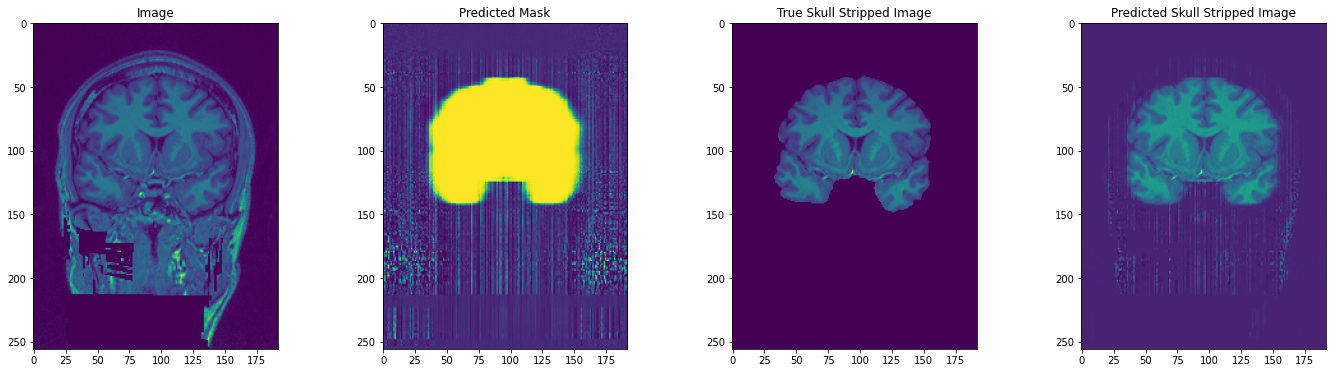

Dice Coefficient: 0.942198


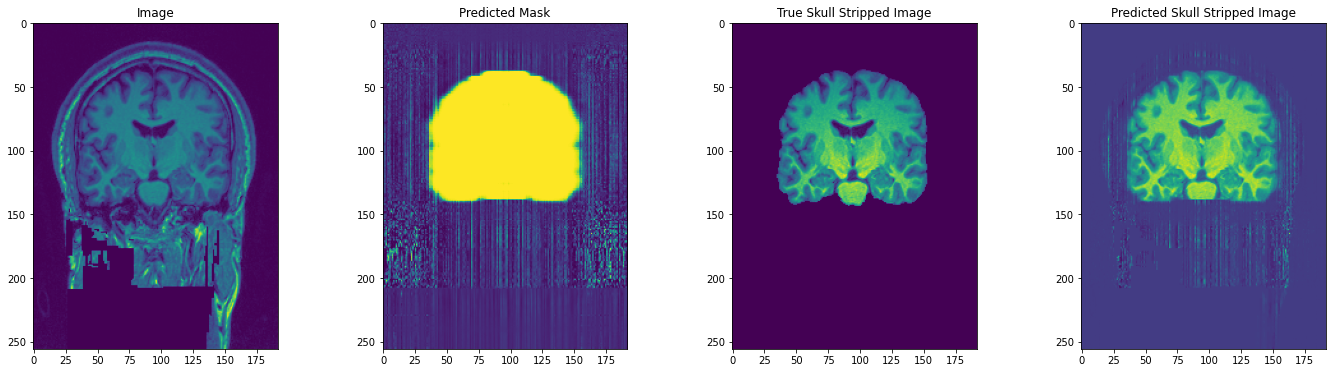

Dice Coefficient: 0.943440


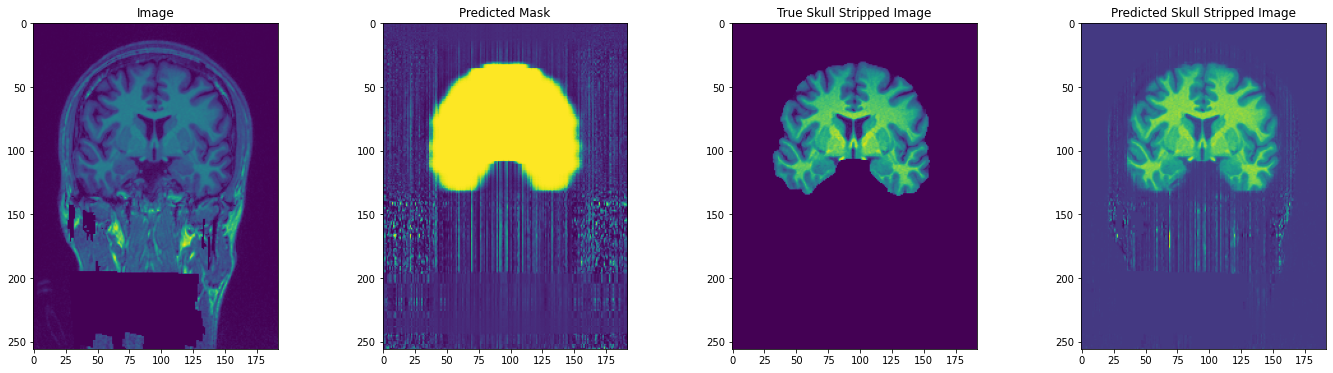

Dice Coefficient: 0.933300


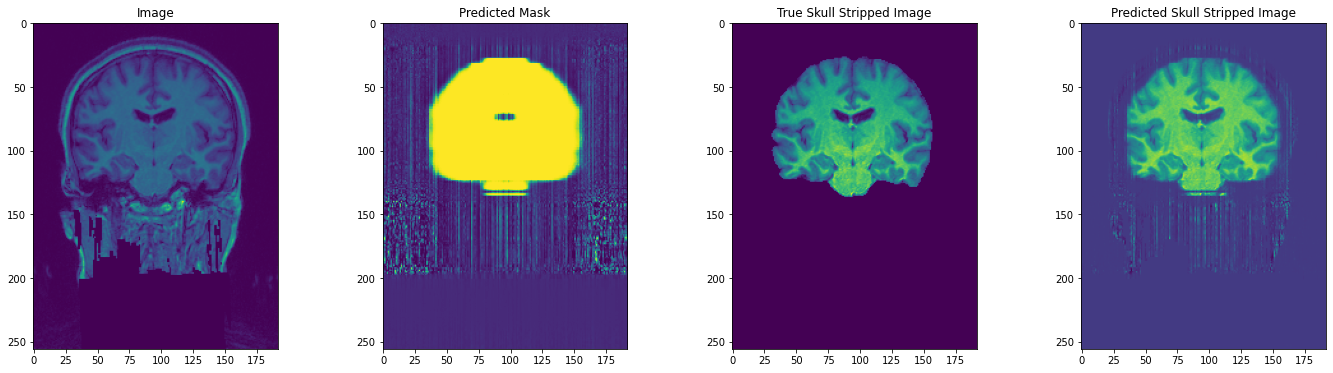

Dice Coefficient: 0.943767


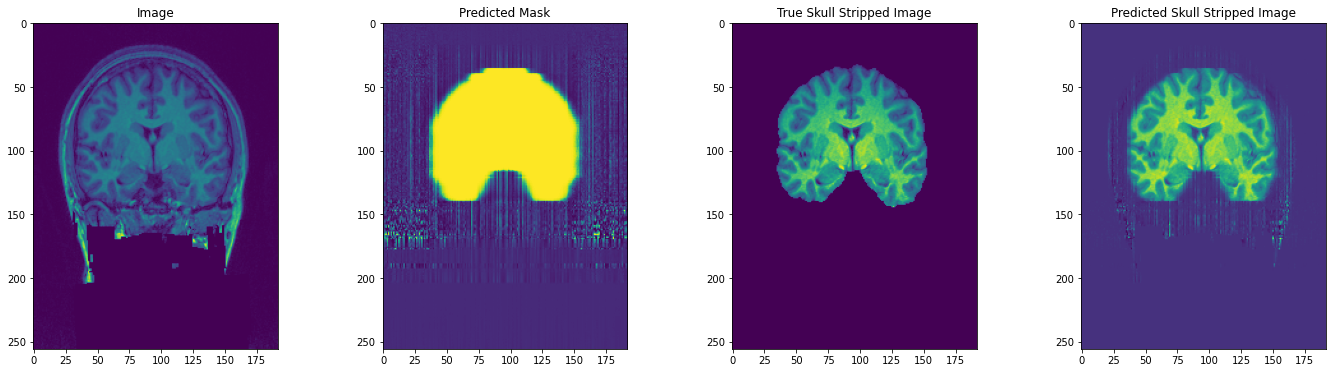

Mean Dice Coeff=0.939966, Std Dice Coeff=0.004099


In [52]:
#Sample n MRI images and Predict
predict_random(5)

In [53]:
os.listdir("/kaggle/")

['lib', 'input', 'working']